##  Before we begin: Dataset
Read and prepare data.

Dataset: MNIST.

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


#Convolutional autoencoder
Network:
- 3x3 Conv2D, filters=16, relu, padding=same
- 2x2 MaxPooling2D, padding=same
- 3x3 Conv2D filters=8, relu, padding=same
- 2x2 MaxPooling2D, padding=same
- 3x3 Conv2D filters=8, relu, padding=same
- 2x2 MaxPooling2D, padding=same
- 3x3 Conv2D filters=8, relu, padding=same
- 2x2 UpSampling2D
- 3x3 Conv2D filters=8, relu, padding=same
- 2x2 UpSampling2D
- 3x3 Conv2D filters=16, relu
- 2x2 UpSampling2D
- 3x3 Conv2D filters=1, sigmoid, padding=same

and train it with adadelta and binary_crossentropy.

Question: What is the size of the input, output and compressed representations?

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta

input = Input(shape=(28, 28, 1))
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input)
maxpooling1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(maxpooling1)
maxpooling2 = MaxPooling2D((2, 2), padding='same')(conv2)
conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(maxpooling2)
maxpooling3 = MaxPooling2D((2, 2), padding='same')(conv3)
conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(maxpooling3)

upsampling1 = UpSampling2D((2, 2))(conv4)
conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(upsampling1)
upsampling2 = UpSampling2D((2, 2))(conv5)
conv6 = Conv2D(16, (3, 3), activation='relu')(upsampling2)
upsampling3 = UpSampling2D((2, 2))(conv6)
output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upsampling3)
autoencoder = Model(inputs=input, outputs=output)
autoencoder.compile(optimizer=Adadelta(learning_rate=0.03), loss='binary_crossentropy', metrics=['acc'])


In [ ]:
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 2s 5ms/step - loss: 0.4520 - acc: 0.7597 - val_loss: 0.2443 - val_acc: 0.7843
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2241 - acc: 0.7786 - val_loss: 0.2139 - val_acc: 0.7752
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2092 - acc: 0.7768 - val_loss: 0.2050 - val_acc: 0.7782
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2009 - acc: 0.7853 - val_loss: 0.1971 - val_acc: 0.7879
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1943 - acc: 0.7894 - val_loss: 0.1915 - val_acc: 0.7907
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1893 - acc: 0.7915 - val_loss: 0.1868 - val_acc: 0.7924
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1851 - acc: 0.7931 - val_loss: 0.1828 - val_acc: 0.7936
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.

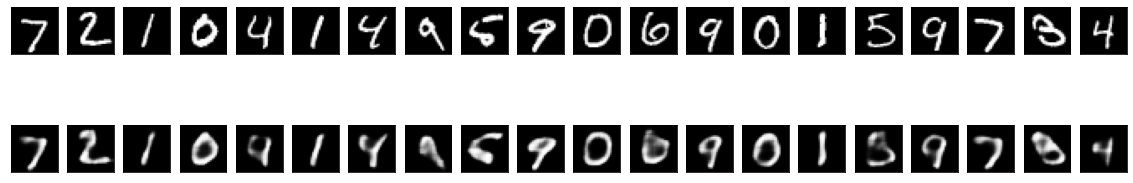

In [ ]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
  # test image
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  # reconstructed image
  ax = plt.subplot(2, n, i + n + 1)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Autoencoder

Let's generate synthetic noisy digits applying a gaussian noise matrix and clipping images between 0 and 1.

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Show sample noisy test images

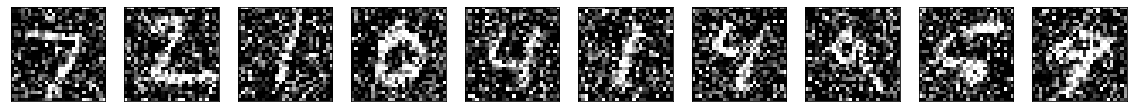

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(x_test_noisy[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Let's define a network:
- 3x3 Conv2D, filters=32, relu, padding=same
- 2x2 MaxPooling2D, padding=same
- 3x3 Conv2D, filters=32, relu, padding=same
- 2x2 MaxPooling2D, padding=same
- 3x3 Conv2D, filters=32, relu, padding=same
- 2x2 UpSampling2D
- 3x3 Conv2D, filters=32, relu, padding=same
- 2x2 UpSampling2D
- 3x3 Conv2D, filters=1, sigmoid, padding=same

and train it with adadelta and binary_crossentropy.

Question: What is the size of the input, output and compressed representations?

In [ ]:
input = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
maxpooling1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpooling1)
maxpooling2 = MaxPooling2D((2, 2), padding='same')(conv2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpooling2)

upsampling1 = UpSampling2D((2, 2))(conv3)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(upsampling1)
upsampling2 = UpSampling2D((2, 2))(conv4)
output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upsampling2)
model = Model(inputs=input, outputs=output)
model.compile(optimizer=Adadelta(learning_rate=0.01), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1510 - acc: 0.8044 - val_loss: 0.1497 - val_acc: 0.8031
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1507 - acc: 0.8044 - val_loss: 0.1495 - val_acc: 0.8043
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1504 - acc: 0.8045 - val_loss: 0.1491 - val_acc: 0.8039
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1497 - acc: 0.8046 - val_loss: 0.1485 - val_acc: 0.8038
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1494 - acc: 0.8047 - val_loss: 0.1482 - val_acc: 0.8037
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1492 - acc: 0.8047 - val_loss: 0.1479 - val_acc: 0.8044
Epoch 8/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1489 - acc: 0.8048 - val_loss: 0.1476 - val_acc: 0.8036
Epoch 9/100
469/469 [==============================] - 2s 5ms/step - 

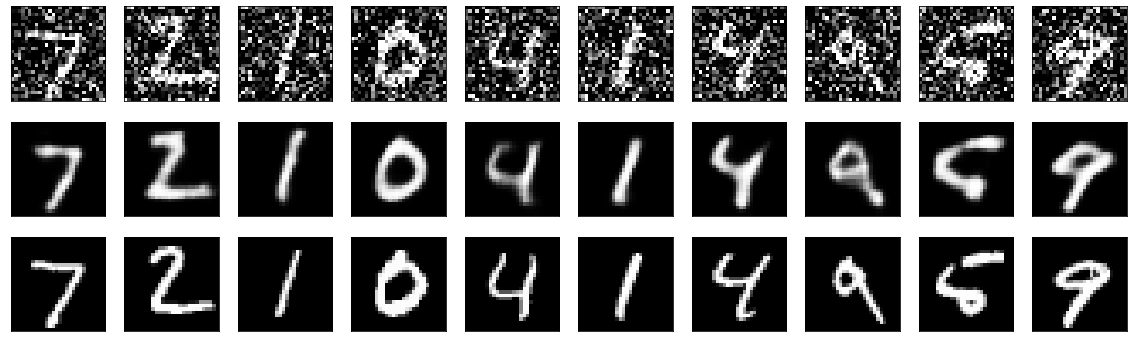

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # x_test_noisy image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed image
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # x_test image
    ax = plt.subplot(3, n, i + n + n + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()